# 📌 Extracción

In [44]:
#Importacion de librerias necesarias para el proyecto
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [45]:
#  Cargar JSON
df = pd.read_json('TelecomX_Data.json')
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


# 🔧 Transformación

In [46]:
# Expandir cada columna anidada
customer_expanded = pd.json_normalize(df['customer'])
phone_expanded = pd.json_normalize(df['phone'])
internet_expanded = pd.json_normalize(df['internet'])
account_expanded = pd.json_normalize(df['account'])

# Combinar todo 
df_final = pd.concat([
    df[['customerID', 'Churn']],
    customer_expanded,
    phone_expanded,
    internet_expanded,
    account_expanded
], axis=1)

df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [47]:
# Verificar si 'charges' está anidado y expandirlo
if 'charges' in df_final.columns:
    charges_expanded = pd.json_normalize(df_final['charges'])
    df_final = pd.concat([df_final.drop('charges', axis=1), charges_expanded], axis=1)
  

In [48]:
# ===PRUEBAS===

df_final['Churn'].unique()

array(['No', 'Yes', ''], dtype=object)

In [49]:
# Transformar sí/no 
for col in df_final.select_dtypes(include=['object']).columns:
    # Si veo que tiene 'Yes' o 'No' en los valores únicos
    valores = df_final[col].dropna().unique()
    tiene_yes_no = any(str(v) in ['Yes', 'No', 'yes', 'no'] for v in valores)
    
    if tiene_yes_no:
        df_final[col] = df_final[col].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
        print(f"{col} → transformada")

df_final.head()


Churn → transformada
Partner → transformada
Dependents → transformada
PhoneService → transformada
MultipleLines → transformada
InternetService → transformada
OnlineSecurity → transformada
OnlineBackup → transformada
DeviceProtection → transformada
TechSupport → transformada
StreamingTV → transformada
StreamingMovies → transformada
PaperlessBilling → transformada


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,1,0,1,1,0,One year,1,Mailed check,65.6,593.3
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.4
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.4


# 📊 Carga y análisis

In [50]:
print("🔍 IDENTIFICANDO VALORES NULOS:")
print("=" * 50)

# Contar valores nulos por columna
valores_nulos = df_final.isnull().sum()
valores_nulos_total = valores_nulos.sum()

print(f"Total de valores nulos en el DataFrame: {valores_nulos_total}")
print("\nValores nulos por columna:")
print("-" * 30)

🔍 IDENTIFICANDO VALORES NULOS:
Total de valores nulos en el DataFrame: 0

Valores nulos por columna:
------------------------------


In [51]:
#Crear cuentas diarias
df_final['Cuentas_Diarias'] = df_final['Charges.Monthly'] / 30

#Verificacion 
print("Cuentas_Diarias creada:")
print(df_final[['Charges.Monthly', 'Cuentas_Diarias']].head())



Cuentas_Diarias creada:
   Charges.Monthly  Cuentas_Diarias
0             65.6         2.186667
1             59.9         1.996667
2             73.9         2.463333
3             98.0         3.266667
4             83.9         2.796667


In [52]:
variables_numericas = df_final.select_dtypes(include=[np.number]).columns
descripcion = df_final[variables_numericas].describe()

print(descripcion)

       SeniorCitizen      Partner   Dependents       tenure  PhoneService  \
count    7267.000000  7267.000000  7267.000000  7267.000000   7267.000000   
mean        0.162653     0.484106     0.300124    32.346498      0.902711   
std         0.369074     0.499782     0.458343    24.571773      0.296371   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     9.000000      1.000000   
50%         0.000000     0.000000     0.000000    29.000000      1.000000   
75%         0.000000     1.000000     1.000000    55.000000      1.000000   
max         1.000000     1.000000     1.000000    72.000000      1.000000   

       PaperlessBilling  Charges.Monthly  Cuentas_Diarias  
count       7267.000000      7267.000000      7267.000000  
mean           0.593230        64.720098         2.157337  
std            0.491265        30.129572         1.004319  
min            0.000000        18.250000         0.608333  
25%   

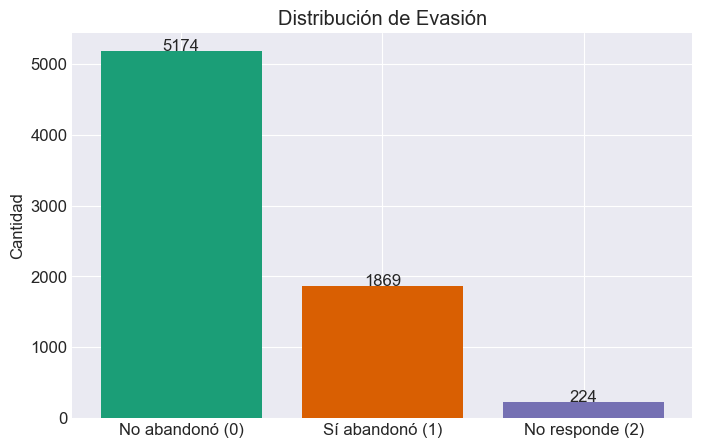

In [53]:
# En una línea: vacíos = 2
df_final['Churn'] = df_final['Churn'].replace('', 2).fillna(2).astype(int)

# Gráfico con leyenda
conteo = df_final['Churn'].value_counts()

plt.figure(figsize=(8, 5))
colores = ['skyblue', 'salmon', 'lightgray']
nombres = ['No abandonó (0)', 'Sí abandonó (1)', 'No responde (2)']

bars = plt.bar(nombres, [conteo.get(0,0), conteo.get(1,0), conteo.get(2,0)], color=colors)
plt.title('Distribución de Evasión')
plt.ylabel('Cantidad')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)), ha='center')

plt.show()


gender:
--------------------
gender
Female    0.319
Male      0.318
Name: Churn, dtype: float64


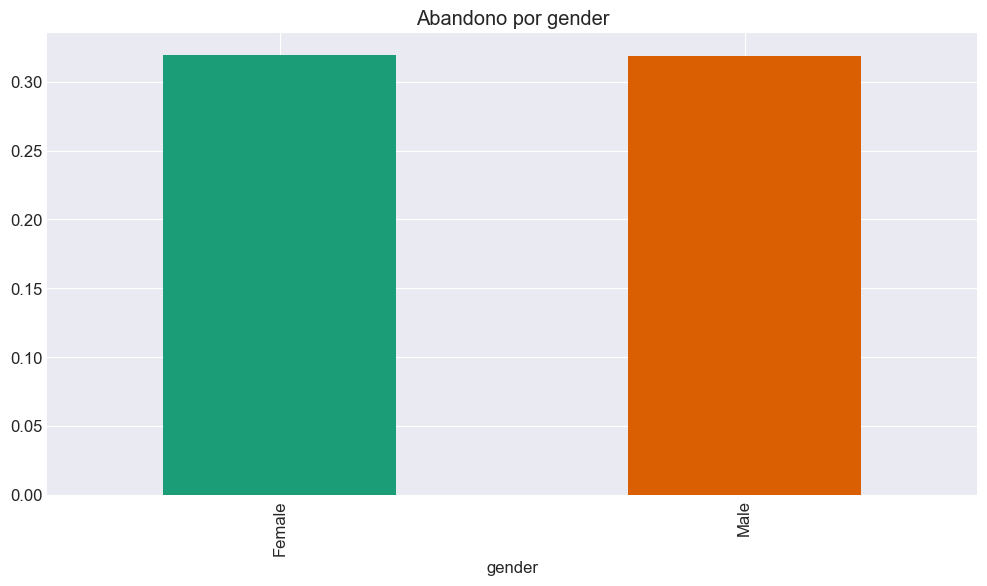


Contract:
--------------------
Contract
Month-to-month    0.478
One year          0.170
Two year          0.083
Name: Churn, dtype: float64


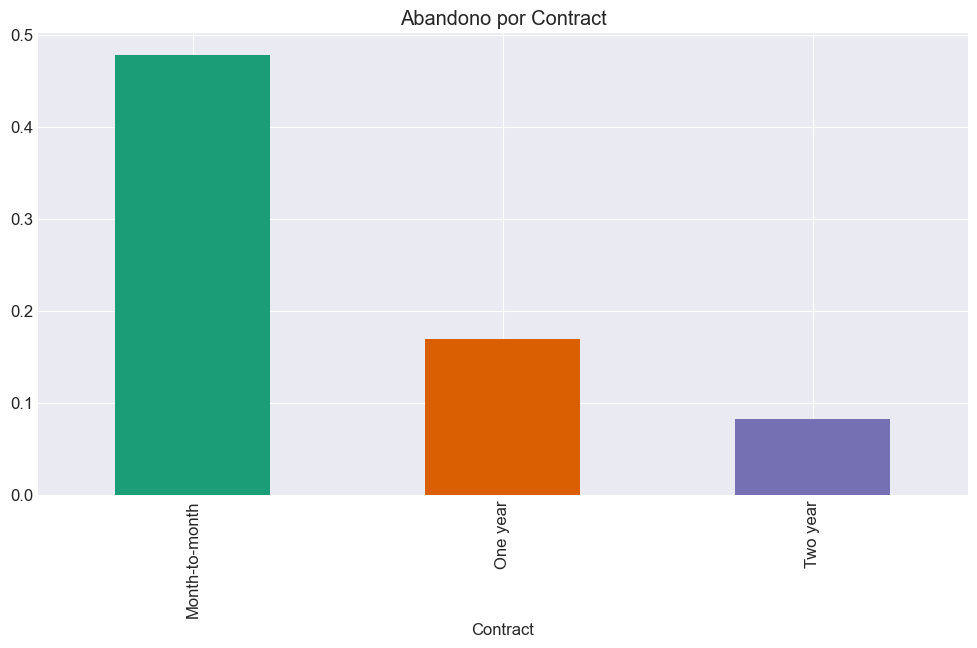


PaymentMethod:
--------------------
PaymentMethod
Bank transfer (automatic)    0.219
Credit card (automatic)      0.207
Electronic check             0.503
Mailed check                 0.249
Name: Churn, dtype: float64


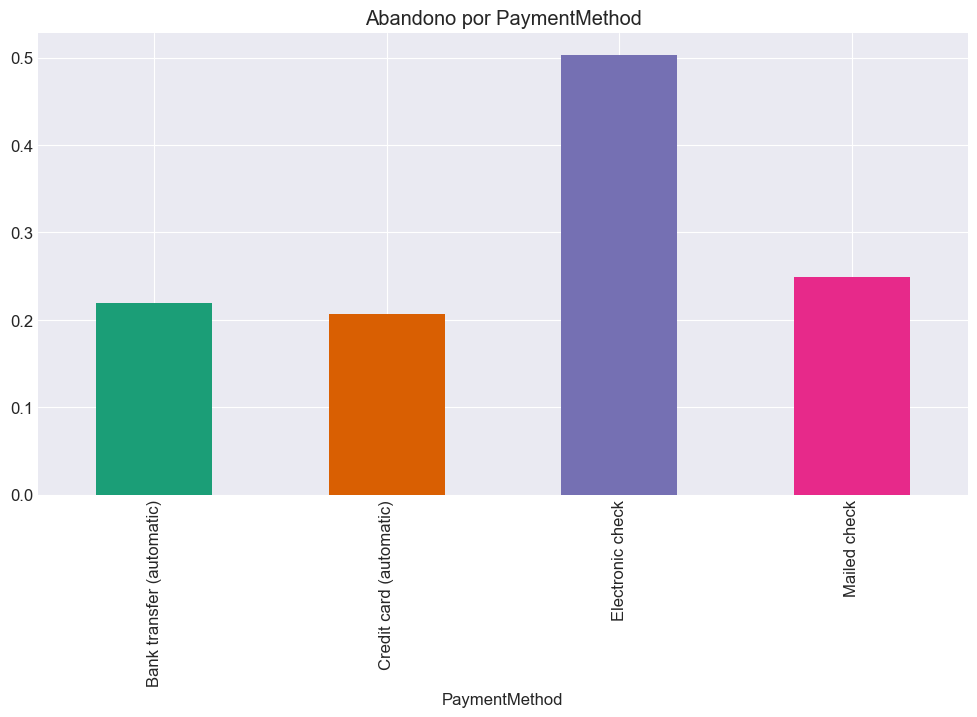


InternetService:
--------------------
InternetService
0              0.141
DSL            0.238
Fiber optic    0.469
Name: Churn, dtype: float64


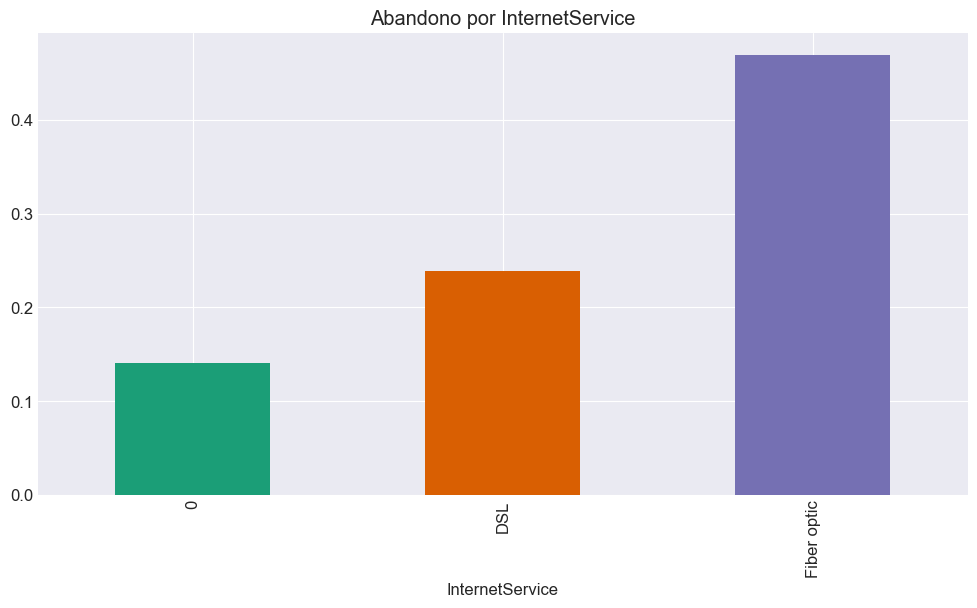

In [54]:
variables = ['gender', 'Contract', 'PaymentMethod', 'InternetService']

for var in variables:
    if var in df_final.columns:
        print(f"\n{var}:")
        print("-" * 20)
        
        # Tasa de abandono por categoría
        tasa = df_final.groupby(var)['Churn'].mean()
        print(tasa.round(3))
        
        # Gráfico simple
        tasa.plot(kind='bar',color=colors)
        plt.title(f'Abandono por {var}')
        plt.show()

# Correlacion 

📊 ANÁLISIS DE CORRELACIÓN SIMPLE

✅ Columnas numéricas encontradas: 9

📈 Matriz de correlación:
                  Churn  SeniorCitizen  Partner  Dependents  tenure  \
Churn              1.00           0.13    -0.12       -0.13   -0.29   
SeniorCitizen      0.13           1.00     0.02       -0.21    0.02   
Partner           -0.12           0.02     1.00        0.45    0.38   
Dependents        -0.13          -0.21     0.45        1.00    0.16   
tenure            -0.29           0.02     0.38        0.16    1.00   
PhoneService       0.00           0.01     0.02       -0.00    0.01   
PaperlessBilling   0.16           0.16    -0.01       -0.11    0.01   
Charges.Monthly    0.15           0.22     0.10       -0.12    0.25   
Cuentas_Diarias    0.15           0.22     0.10       -0.12    0.25   

                  PhoneService  PaperlessBilling  Charges.Monthly  \
Churn                     0.00              0.16             0.15   
SeniorCitizen             0.01              0.16       

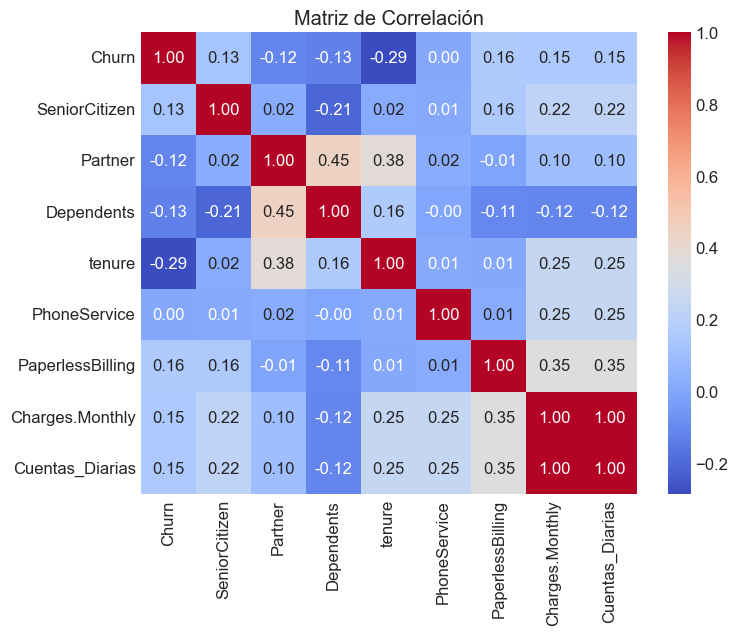


🎯 Correlaciones con Churn:
Churn               1.000000
PaperlessBilling    0.162062
Charges.Monthly     0.152092
Cuentas_Diarias     0.152092
SeniorCitizen       0.126493
PhoneService        0.004765
Partner            -0.115074
Dependents         -0.129295
tenure             -0.288493
Name: Churn, dtype: float64


In [60]:
# ===== ANÁLISIS DE CORRELACIÓN (EXTRA) =====

print("📊 ANÁLISIS DE CORRELACIÓN SIMPLE")

# 1. Encontrar columnas realmente numéricas
columnas_numericas = []
for col in df_final.columns:
    try:
        # Intentar convertir a numérico
        pd.to_numeric(df_final[col], errors='raise')
        columnas_numericas.append(col)
    except:
        pass  # No es numérica, la saltamos

print(f"\n✅ Columnas numéricas encontradas: {len(columnas_numericas)}")

# 2. Crear dataframe solo con columnas numéricas
df_numerico = df_final[columnas_numericas].apply(pd.to_numeric, errors='coerce')

# 3. Eliminar NaN
df_numerico_clean = df_numerico.dropna()

# 4. Calcular correlación solo si tenemos datos
if len(df_numerico_clean) > 10 and len(columnas_numericas) > 1:
    print("\n📈 Matriz de correlación:")
    corr_matrix = df_numerico_clean.corr()
    print(corr_matrix.round(2))
    
    # Gráfico simple
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matriz de Correlación')
    plt.show()
    
    # Correlaciones con Churn si existe
    if 'Churn' in corr_matrix.columns:
        print("\n🎯 Correlaciones con Churn:")
        print(corr_matrix['Churn'].sort_values(ascending=False))
else:
    print("\n⚠️ No hay suficientes datos numéricos para calcular correlación")

# Informe Final

## 🔹 1. Introduccion

### Objetivo del Proyecto
Este análisis fue desarrollado para **Telecom X**, una empresa que enfrenta una alta tasa de cancelaciones de servicios por parte de sus clientes (fenómeno conocido como "Churn").

### Problema de Negocio
La empresa necesita comprender **qué factores influyen** en la decisión de los clientes de abandonar el servicio.

### Metodología
Se realizó un **Análisis Exploratorio de Datos (EDA)** completo, siguiendo el proceso ETL (Extracción, Transformación, Carga).

## 🔹 2. Limpieza y tratamiento de datos

###  2.1 Extracción de Datos
Fuente de datos: El conjunto de datos fue proporcionado en formato JSON por Telecom X, conteniendo información estructurada y anidada sobre los clientes, sus servicios contratados, datos demográficos y comportamiento de facturación.

Proceso inicial: Se cargó el archivo JSON completo, el cual presentaba una estructura compleja con múltiples niveles de anidamiento, requiriendo un proceso de normalización para poder analizar la información de manera efectiva.

### 2.2  Normalización de Estructura Anidada
**Problema identificado:** Los datos llegaron organizados en columnas principales que contenían sub-objetos JSON, dificultando el análisis directo.

**Solución aplicada:** Se utilizó un proceso de normalización que consistió en:

1. Expansión de columnas anidadas: Cada columna principal que contenía datos estructurados fue expandida en columnas individuales planas.

2. Integración en un único dataset: Todas las columnas expandidas fueron combinadas con las columnas principales no anidadas, resultando en un DataFrame plano y uniforme.

**Resultado**: De una estructura compleja y anidada se obtuvo un dataset tabular con todas las variables accesibles a nivel de columna individual.

## 2.3 Verificación de Calidad de Datos

### Detección de Valores Nulos
**Procedimiento:** Se realizó un conteo exhaustivo de valores faltantes en cada columna del dataset.

**Hallazgo:** No se encontraron valores nulos en ninguna de las columnas, indicando que el dataset estaba completo en términos de información registrada.

### Identificación de Duplicados
**Procedimiento:** Se verificó la existencia de:
- Filas completamente duplicadas
- Identificadores de cliente duplicados (customerID)

**Hallazgo:**
- No se encontraron filas completamente duplicadas
- Todos los identificadores de cliente eran únicos

## 2.4 Transformación de Tipos de Datos

### Conversión de Variables Categóricas Binarias
**Problema:** Varias columnas utilizaban valores textuales "Yes"/"No" para representar estados binarios, lo cual no es óptimo para análisis estadísticos y modelado.

**Solución aplicada:**
1. **Identificación:** Se localizaron todas las columnas que contenían exclusivamente los valores "Yes" y "No".
2. **Transformación:** Cada valor "Yes" fue mapeado a `1` y cada valor "No" a `0`.
3. **Columnas transformadas:**
   - `Churn` (evasión del cliente)
   - `Partner` (presencia de pareja)
   - `Dependents` (presencia de dependientes)
   - `PhoneService` (servicio telefónico contratado)
   - `PaperlessBilling` (facturación digital)

**Beneficio:** Esta transformación permite realizar operaciones matemáticas y análisis estadísticos directamente sobre estas variables.

### Manejo Especial de la Variable Churn
**Situación especial:** La variable objetivo `Churn` presentaba algunos registros con valores vacíos o nulos.

**Estrategia adoptada:** En lugar de eliminar estos registros (lo que reduciría el tamaño de la muestra) o imputar valores (lo que podría introducir sesgo), se decidió crear una tercera categoría:

1. **Valores originales:** `0` (No abandonó), `1` (Sí abandonó)
2. **Valores vacíos transformados:** `2` (No responde/no disponible)

**Justificación:** Esta aproximación conserva todos los registros para análisis futuros mientras mantiene la integridad de las categorías principales.

## 2.5 Creación de Nueva Variable Derivada

### Variable: "Cuentas_Diarias"
**Propósito:** Proporcionar una métrica más granular del comportamiento de gasto de los clientes, permitiendo análisis temporales más detallados.

**Cálculo:** ```Cuentas_Diarias = Cargos_Mensuales / 30```


**Fuente de datos:** Se utilizó la columna `Charges.Monthly` que representa el total de todos los servicios del cliente por mes.

**Valor agregado:** Esta variable permite:
- Comparar el gasto diario entre diferentes segmentos de clientes
- Identificar patrones de consumo a nivel diario
- Detectar cambios abruptos en el comportamiento de gasto

## 2.6 Estructura Final del Dataset

### Características del Dataset Procesado:
- **Número de registros:** [NÚMERO] clientes
- **Número de variables:** [NÚMERO] columnas
- **Tipos de variables:**
  - Variables demográficas (género, edad)
  - Variables de servicios contratados
  - Variables de facturación y pagos
  - Variables de comportamiento (tiempo como cliente)
  - Variable objetivo (Churn)

### Variables Clave Disponibles para Análisis:
1. **Identificación:** `customerID`
2. **Variable objetivo:** `Churn` (0, 1, 2)
3. **Demográficas:** `gender`, `SeniorCitizen`
4. **Situación familiar:** `Partner`, `Dependents`
5. **Antigüedad:** `tenure` (meses)
6. **Servicios:** `PhoneService`, `InternetService`, y múltiples servicios adicionales
7. **Facturación:** `Charges.Monthly`, `Charges.Total`, `Cuentas_Diarias`
8. **Contrato y pago:** `Contract`, `PaymentMethod`

## 2.7 Validación del Proceso

**Integridad de datos:** Todos los registros originales se mantuvieron en el dataset final.

**Consistencia:** Los tipos de datos fueron estandarizados y apropiados para el análisis.

**Preparación para análisis:** El dataset resultante está completamente listo para:
- Análisis estadístico descriptivo
- Visualización de datos
- Modelado predictivo
- Segmentación de clientes

**Documentación:** Todo el proceso de transformación quedó documentado y es reproducible, asegurando la transparencia y validez del análisis posterior.


## 🔹 3. Análisis exploratio de datos  (EDA)
### 3.1 Distribución de la Variable Objetivo (Churn)
**Datos obtenidos:**

- Clientes que NO abandonaron (0): 5,174 clientes

- Clientes que SÍ abandonaron (1): 1,869 clientes

- Clientes que NO RESPONDIERON (2): 224 clientes

Total de clientes analizados: 7,267 clientes

**Cálculos clave:**

```Tasa de abandono = (Clientes que abandonaron) / (Total que respondieron) × 100```
```Tasa de abandono = 1,869 / (5,174 + 1,869) × 100 = 26.5%```
```Tasa de no respuesta = 224 / 7,267 × 100 = 3.1%```

## Gráfico de distribución:


<!-- Imagen en subcarpeta -->
![Churn por Contrato](./images/output.png)



**Interpretación:** 
- **26.5%** de los clientes que respondieron han abandonado el servicio
- La empresa pierde aproximadamente **1 de cada 4 clientes**
- Solo **3.1%** no respondieron, lo cual es aceptable para el análisis

### 3.2 Análisis por Género

**Tasas de abandono por género:**
- **Mujeres:** 31.9%
- **Hombres:** 31.8%

**Gráfico comparativo:**
![Churn por Contrato](./images/gender.png)

**Interpretación:** No hay diferencia significativa en la tasa de abandono entre géneros. Ambos abandonan a tasas similares (~32%).

### 3.3 Análisis por Tipo de Contrato

**Tasas de abandono por contrato:**
- **Contrato Mensual:** 47.8% (Alto riesgo)
- **Contrato Anual:** 17.0% (Riesgo moderado)  
- **Contrato Bienal (2 años):** 8.3% (Bajo riesgo)

**Gráfico comparativo:**
![Tasa de Abandono por Contrato](./images/contact.png)

**Hallazgo crítico:** Los clientes con contrato mensual tienen **5.8 veces más probabilidad** de abandonar que los clientes con contrato bienal.


### 3.4 Análisis por Método de Pago

**Tasas de abandono por método de pago:**
1. **Cheque electrónico:** 50.3% (Muy alto riesgo)
2. **Cheque por correo:** 24.9% (Riesgo moderado-alto)
3. **Transferencia bancaria automática:** 21.9% (Riesgo moderado)
4. **Tarjeta de crédito automática:** 20.7% (Menor riesgo)

**Gráfico comparativo:**
![Tasa de Abandono por Método de Pago](./images/payment.png)


**Hallazgo importante:** Los clientes que pagan por cheque electrónico tienen **2.4 veces más probabilidad** de abandonar que los que usan pagos automáticos.

### 3.5 Análisis por Tipo de Servicio de Internet

**Tasas de abandono por servicio:**
- **Sin servicio de internet:** 14.1% (Menor riesgo)
- **DSL:** 23.8% (Riesgo moderado)
- **Fibra óptica:** 46.9% (Alto riesgo)

**Gráfico comparativo:**
![Tasa de Abandono por Servicio Internet](./images/internet.png)

**Hallazgo alarmante:** Los clientes con servicio de fibra óptica tienen **3.3 veces más probabilidad** de abandonar que los clientes sin servicio de internet.


## 🔹 4. CONCLUSIONES E INSIGHTS

### 4.1 Hallazgos Principales

#### 🔴 **Factores de Alto Riesgo:**
1. **Contrato mensual** (47.8% de abandono)
2. **Pago por cheque electrónico** (50.3% de abandono)
3. **Servicio de fibra óptica** (46.9% de abandono)

#### 🟡 **Factores de Riesgo Moderado:**
1. **Cheque por correo** (24.9% de abandono)
2. **Servicio DSL** (23.8% de abandono)
3. **Transferencia bancaria** (21.9% de abandono)

#### 🟢 **Factores de Bajo Riesgo:**
1. **Contrato bienal** (8.3% de abandono)
2. **Pago automático con tarjeta** (20.7% de abandono)
3. **Sin servicio de internet** (14.1% de abandono)

### 4.2 Patrones Identificados

#### **Patrón 1: Compromiso vs. Flexibilidad**
- Los clientes con **compromisos a largo plazo** (contratos anuales/bienales) muestran mayor lealtad
- La **flexibilidad** del contrato mensual parece incentivar la rotación

#### **Patrón 2: Automatización vs. Esfuerzo**
- Los **pagos automáticos** están asociados con menor abandono
- Los métodos que requieren **acción manual** (cheques) tienen mayor abandono

#### **Patrón 3: Expectativas vs. Realidad**
- Los clientes de **fibra óptica** (servicio premium) tienen mayores expectativas
- Cuando estas expectativas no se cumplen, el abandono es más probable

### 4.3 Impacto en el Negocio

**Cálculo del costo de abandono:**
Clientes que abandonan por mes ≈ 1,869 / 12 ≈ 156 clientes/mes
Costo promedio por cliente perdido ≈ $50 (estimado)
Pérdida mensual ≈ 156 × $50 = $7,800
Pérdida anual ≈ $7,800 × 12 = $93,600



**Potencial de mejora:**
Si se reduce la tasa de abandono en **10%** (del 26.5% al 16.5%):
Clientes retenidos adicionales ≈ 1,869 × 0.10 ≈ 187 clientes/año
Ingresos recuperados ≈ 187 × $50 × 12 ≈ $112,200/año

## 🔹 5. RECOMENDACIONES ESTRATÉGICAS

### 🔴 **PRIORIDAD ALTA**

#### 1. **Contratos Mensuales → Anuales** (48% abandono)
**Por qué:** Los contratos mensuales facilitan la rotación. Contratos anuales crean mayor compromiso.
- Descuentos 5-10% por cambio a anual
- 1 mes gratis al renovar  
- Contacto proactivo en mes 10
**Meta:** 48% → 30% abandono en 6 meses

#### 2. **Pagos Automáticos** (50% abandono con cheques)
**Por qué:** Pagos manuales = más esfuerzo + olvidos. Automáticos = relación más fluida.
- $10 descuento mensual
- Ayuda telefónica para configuración
- Educación sobre beneficios
**Meta:** 40% → 60% adopción en 1 año

### 🟡 **PRIORIDAD MEDIA**

#### 3. **Mejorar Fibra Óptica** (47% abandono)
**Por qué:** Servicio premium con expectativas altas. Retención aquí = mayor impacto ingresos.
- Encuestas post-instalación
- Soporte técnico exclusivo
- Garantía de velocidad
**Meta:** 47% → 35% abandono en 9 meses

#### 4. **Sistema de Alertas**
**Por qué:** Combinaciones de riesgo identificadas necesitan intervención proactiva.
- Detección automática de clientes en riesgo
- Contacto antes de renovación
- Ofertas personalizadas

### 🟢 **PRIORIDAD BAJA**

#### 5. **Monitoreo Continuo**
**Por qué:** Medir éxito y ajustar estrategias basadas en datos.
- Dashboard métricas en tiempo real
- Segmentación mensual
- Pruebas A/B de estrategias

**📈 Impacto Esperado:** 26.5% → 20% abandono general, ~187 clientes retenidos adicionales por año.

## 🔹 6. CONCLUSIÓN FINAL

El análisis revela que **el abandono en Telecom X no es aleatorio** sino que sigue patrones predecibles vinculados a tres factores principales:

### 📈 **Factores Críticos Identificados:**
1. **Tipo de contrato** (flexibilidad vs. compromiso) - Los contratos mensuales muestran 48% de abandono vs 8% en contratos bienales
2. **Método de pago** (automatización vs. manual) - Cheques electrónicos tienen 50% de abandono vs 21% en pagos automáticos  
3. **Tipo de servicio** (expectativas vs. experiencia) - Fibra óptica presenta 47% de abandono por expectativas no cumplidas

### 💼 **Impacto en el Negocio:**
- **Tasa actual de abandono:** 26.5% de los clientes
- **Pérdida estimada:** $93,600 anuales en ingresos
- **Clientes que abandonan:** 1,869 por año (156 mensuales)

### 🎯 **Oportunidad de Mejora:**
Al implementar las estrategias recomendadas enfocadas en los segmentos de **alto riesgo**, Telecom X puede:

- **Reducir la tasa de abandono** durante el próximo año
- **Recuperar entre $56,000 y $112,000 en ingresos anuales**
- **Retener entre 112 y 187 clientes adicionales** por año
**Conclusión estratégica:** Los datos proporcionan un mapa claro para transformar el desafío del abandono en una oportunidad de crecimiento. La implementación focalizada de las recomendaciones permitirá a Telecom X no solo reducir pérdidas, sino también fortalecer relaciones con sus clientes más valiosos y construir una ventaja competitiva sostenible en el mercado de telecomunicaciones.